In [10]:
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
url = "https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-04-01"
driver = webdriver.PhantomJS()
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])
driver.implicitly_wait(10)
driver.get(url)

In [12]:
driver.current_url

'https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-04-01'

In [13]:
driver.save_screenshot(r'flight_explorer.png')

True

In [14]:
s = BeautifulSoup(driver.page_source, "lxml")

<!DOCTYPE html>
<html lang="en-US"><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="baseUrl=/flights/explore//static/" name="deals::gwt:property"/><title>Explore flights</title><meta content="Explore flights" name="description"/><script async="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.yoTdpQipo6s.O/m=gapi_iframes,googleapis_client,plusone/rt=j/sv=1/d=1/ed=1/am=AAE/rs=AHpOoo9_VhuRoUovwpPPf5LqLZd-dmCnxw/cb=gapi.loaded_0"></script><script language="javascript" type="text/javascript">
var __JS_ILT__ = new Date();
</script>
<style type="text/css">.gb_5a{background:white;height:100%;position:fixed;right:0;top:0;width:420px;z-index:1001}.gb_6a.gb_5a{left:0;min-height:400px;top:64px;width:initial}.gb_5a>button:only-of-type{background:url('https://www.gstatic.com/images/icons/material/system/1x/close_grey600_24dp.png');background-position:center;border-width:0;cursor:pointer;font-size:24px;height:20px;left:92%;position:relative;t
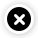
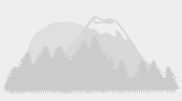

In [15]:
s

In [16]:
best_price_tags = s.findAll('div', 'CTPFVNB-w-e')
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace('$','')))

In [17]:
best_price_tags

[<div class="CTPFVNB-w-e" style="top: 38.48956834148889px;">$598</div>,
 <div class="CTPFVNB-w-e" style="top: 47.26251754796444px;">$628</div>,
 <div class="CTPFVNB-w-e" style="top: 28.175860899067004px;">$866</div>,
 <div class="CTPFVNB-w-e" style="top: 42.99697075375579px;">$870</div>]

In [18]:
best_price = best_prices[0]

In [19]:
best_height_tags = s.findAll('div', 'CTPFVNB-w-f')
best_heights = []
for t in best_height_tags:
    best_heights.append(float(t.attrs['style'].split('height:')[1].replace('px;','')))

In [20]:
best_height = best_heights[0]
best_height

67.51043165851111

In [21]:
# Then we can calculate the price per pixel of the height
pph = np.array(best_price)/np.array(best_height)

In [22]:
# retrieve the bar heights for all flights in each city
cities = s.findAll('div', 'CTPFVNB-w-o')

In [23]:
hlist=[]
for bar in cities[0].findAll('div', 'CTPFVNB-w-x'):
    hlist.append(float(bar['style'].split('height: ')[1].replace('px;',''))*pph)

In [24]:
fares = pd.DataFrame(hlist, columns=['price'])

In [25]:
fares.min()

price    598.0
dtype: float64

In [26]:
fares.median()

price    676.677625
dtype: float64

In [27]:
fares.describe()

,price
count,60.000000
mean,682.882080
std,85.663323
min,598.000000
25%,598.000000
50%,676.677625
75%,745.545572
max,921.519191


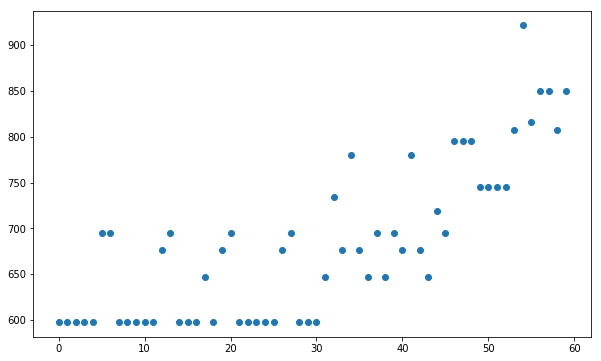

In [28]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(np.arange(len(fares['price'])),fares['price']);

In [29]:
px = [x for x in fares['price']]
ff = pd.DataFrame(px, columns=['fare']).reset_index()

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Text(0.5,1.01,'Total Clusters: 5')

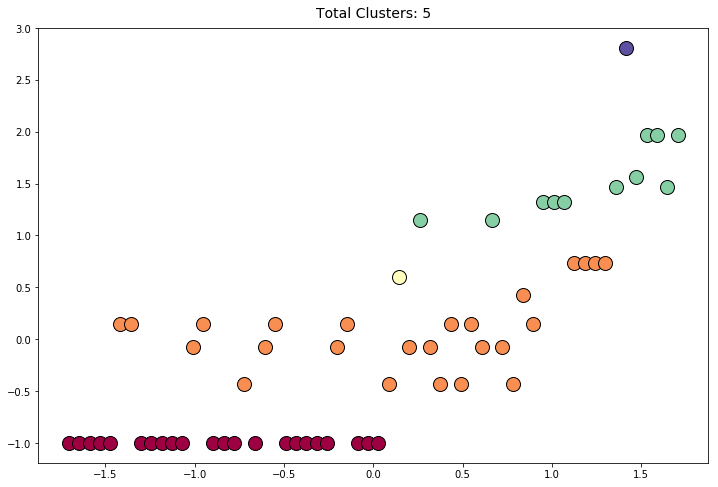

In [31]:
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps=.5, min_samples=1).fit(X)

labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))

plt.subplots(figsize=(12,8))

for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor=c,
             markeredgecolor='k',
             markersize=14)

plt.title("Total Clusters: {}".format(clusters),
          fontsize=14, y=1.01)

In [32]:
def test_clusters(data_series, eps_val, swap_index, swap_value):
    data_series[swap_index] = swap_value
    ff = pd.DataFrame(data_series, columns=['fare']).reset_index()
    X = StandardScaler().fit_transform(ff)
    db = DBSCAN(eps=eps_val, min_samples=1).fit(X)

    labels = db.labels_
    clusters = len(set(labels))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0,
                            1, len(unique_labels)))

    plt.subplots(figsize=(12,8))

    for k, c in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o',
                 markerfacecolor=c,
                 markeredgecolor='k',
                 markersize=14)

    plt.title("Total Clusters: {}".format(clusters),
              fontsize=14, y=1.01)

In [33]:
px = [x for x in fares['price']]

In [34]:
px[15]

598.0

In [35]:
# test_clusters(px, 1.8, 15, 420.0)

In [36]:
pf = pd.concat([ff,pd.DataFrame(db.labels_, columns=['cluster'])], axis=1)
pf

,index,fare,cluster
0,0,598.000000,0
1,1,598.000000,0
2,2,598.000000,0
3,3,598.000000,0
4,4,598.000000,0
5,5,695.095797,1
6,6,695.095797,1
7,7,598.000000,0
8,8,598.000000,0
9,9,598.000000,0


In [37]:
rf = pf.groupby('cluster')['fare'].agg(['min','count']).sort_values('min', ascending=True)
rf

,min,count
cluster,,
0,598.000000,22
1,646.647997,25
2,734.134313,1
3,780.580138,11
4,921.519191,1


In [38]:
rf.describe([.10,.25,.5,.75,.9])

,min,count
count,5.000000,5.000000
mean,736.176328,12.000000
std,125.932387,11.313708
min,598.000000,1.000000
10%,617.459199,1.000000
25%,646.647997,1.000000
50%,734.134313,11.000000
75%,780.580138,22.000000
90%,865.143570,23.800000
max,921.519191,25.000000


In [39]:
rf['count'].quantile(.10)

1.0

In [40]:
pd.Series([50,6,4]).quantile(.10)

4.4